# Using AWS Textrack to Process Financial Reports

References:

- [Accelerate performance using a custom chunking mechanism with Amazon Bedrock](https://aws.amazon.com/blogs/machine-learning/accelerate-performance-using-a-custom-chunking-mechanism-with-amazon-bedrock/)
- [Amazon Textract’s new Layout feature introduces efficiencies in general purpose and generative AI document processing tasks](https://aws.amazon.com/blogs/machine-learning/amazon-textracts-new-layout-feature-introduces-efficiencies-in-general-purpose-and-generative-ai-document-processing-tasks/)
- [Analyse PDFs at Scale with Amazon Textract — Part 1](https://servian.dev/analyse-pdfs-at-scale-with-amazon-textract-part-1-963404f5a779)
- [Intelligent document processing with AWS AI services: Part 1](https://aws.amazon.com/blogs/machine-learning/part-1-intelligent-document-processing-with-aws-ai-services/)
- [Guidance for Intelligent Document Processing on AWS](https://aws.amazon.com/solutions/guidance/intelligent-document-processing-on-aws/?did=sl_card&trk=sl_card)
- [amazon-textract-textractor](https://github.com/aws-samples/amazon-textract-textractor)
- [Getting started with AWS Textract — with Python](https://medium.com/@amanshitta/getting-started-with-aws-textract-with-python-in-progress-2dd6dfd723ad)
- [Best Practices for Amazon Textract](https://docs.aws.amazon.com/textract/latest/dg/textract-best-practices.html)
- [amazon-textrack-code-samples](https://github.com/aws-samples/amazon-textract-code-samples/tree/master/python)

In [ ]:
!brew install poppler

In [110]:
#!pip install amazon-textract-helper
!pip install amazon-textract-textractor
!pip install pdf2image
!pip install python-dotenv


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [113]:
import os

# Setup AKSK environment variables

## Content Extraction using Textract

### Download file from S3

In [115]:
s3_file = { 'bucket_name': 'bedrock-460453255610',
        'object_key': 'financial-reports-canopy/JPM Anonymised.pdf',
           'local_file_path': './JPM Anonymised.pdf'
    }

In [116]:
import boto3

def download_file_from_s3(bucket_name:str, object_key:str, local_file_path:str)->bool:
    """
    Download a file from S3 bucket.
    Input:
        - bucket_name: S3 bucket name
        - object_key: Key to the object to be downloaded
        - local_path_path: Path to the downloaded file including file name
    Output:
        - Return True if download is successful, else return False
    """
    # Create an S3 client
    s3 = boto3.client('s3')

    try:
        # Download the file from S3
        s3.download_file(bucket_name, object_key, local_file_path)
        print(f"File downloaded successfully to {local_file_path}")
        return True
    except Exception as e:
        print(f"Error downloading file: {e}")
        return False

In [117]:
download_file_from_s3(s3_file['bucket_name'], s3_file['object_key'], s3_file['local_file_path'])

File downloaded successfully to ./JPM Anonymised.pdf


### Export Each Page to PNG

Create folder to store the images.

In [118]:
from pathlib import Path

def get_file_path_stem(file_path:str)->str:
    """
    Get file path without file extension.
    Input:
        - file_path: Path to a file including file name
    Output:
        - Path to the file without file extension
    """    
    file = Path(file_path)
    stem_with_path = f'{file.parent}/{file.stem}'    
    return stem_with_path


output_dir_path = get_file_path_stem(s3_file['local_file_path'])
Path(output_dir_path).mkdir(parents=True, exist_ok=True)
print(output_dir_path)

./JPM Anonymised


Export PDF pages into images.

In [120]:
from pdf2image import convert_from_path
from typing import List

def export_pdf_pages_to_images(pdf_path:str, output_dir:str)->List[str]:
    """
    Export each page in PDF file into an image.
    Input:
        - pdf_path: Path to the PDF file
        - output_dir: Path to the folder which stores the image files
    Output:
        - List of file path to the generated image files
    """
    images = convert_from_path(pdf_path, dpi=300)  # Set dpi for high resolution

    output_files = []
    # Save each page as an image file
    for i, image in enumerate(images):
        image_path = f'{output_dir}/page_{i + 1}.png'  # Save as PNG for high quality
        image.save(image_path, 'PNG')
        output_files.append(image_path)

    return output_files


output_files = export_pdf_pages_to_images(pdf_path= s3_file['local_file_path'], output_dir = output_dir_path)
print(output_files)

['./JPM Anonymised/page_1.png', './JPM Anonymised/page_2.png', './JPM Anonymised/page_3.png', './JPM Anonymised/page_4.png', './JPM Anonymised/page_5.png', './JPM Anonymised/page_6.png', './JPM Anonymised/page_7.png', './JPM Anonymised/page_8.png', './JPM Anonymised/page_9.png', './JPM Anonymised/page_10.png', './JPM Anonymised/page_11.png', './JPM Anonymised/page_12.png', './JPM Anonymised/page_13.png', './JPM Anonymised/page_14.png', './JPM Anonymised/page_15.png', './JPM Anonymised/page_16.png', './JPM Anonymised/page_17.png', './JPM Anonymised/page_18.png', './JPM Anonymised/page_19.png', './JPM Anonymised/page_20.png', './JPM Anonymised/page_21.png', './JPM Anonymised/page_22.png', './JPM Anonymised/page_23.png', './JPM Anonymised/page_24.png', './JPM Anonymised/page_25.png', './JPM Anonymised/page_26.png', './JPM Anonymised/page_27.png', './JPM Anonymised/page_28.png', './JPM Anonymised/page_29.png', './JPM Anonymised/page_30.png', './JPM Anonymised/page_31.png', './JPM Anonymise

### Extract Text from Each Image

In [121]:
from textractor import Textractor
from textractor.data.constants import TextractFeatures
from textractor.entities.document import Document


def extract_page_from_image(input_doc_path:str)->Document:
    """
    Extract the data in a document file.
    Input: 
        - input_doc_path: Path to the document file
    Output: Document object which contains the page
    """
    extractor = Textractor()

    document = extractor.analyze_document(
                   file_source=input_doc_path,
                   features=[TextractFeatures.LAYOUT, TextractFeatures.TABLES, TextractFeatures.FORMS],
                   save_image=True)

    return document


In [122]:
# Note: Use page list instead because document.pages is not ordered.
document = Document()

for input_document in output_files:
    print(f"Extracting {input_document}...")
    doc = extract_page_from_image(input_document)
    document.pages.extend(doc.pages)

Extracting ./JPM Anonymised/page_1.png...
Extracting ./JPM Anonymised/page_2.png...
Extracting ./JPM Anonymised/page_3.png...
Extracting ./JPM Anonymised/page_4.png...
Extracting ./JPM Anonymised/page_5.png...
Extracting ./JPM Anonymised/page_6.png...
Extracting ./JPM Anonymised/page_7.png...
Extracting ./JPM Anonymised/page_8.png...
Extracting ./JPM Anonymised/page_9.png...
Extracting ./JPM Anonymised/page_10.png...
Extracting ./JPM Anonymised/page_11.png...
Extracting ./JPM Anonymised/page_12.png...
Extracting ./JPM Anonymised/page_13.png...
Extracting ./JPM Anonymised/page_14.png...
Extracting ./JPM Anonymised/page_15.png...
Extracting ./JPM Anonymised/page_16.png...
Extracting ./JPM Anonymised/page_17.png...
Extracting ./JPM Anonymised/page_18.png...
Extracting ./JPM Anonymised/page_19.png...
Extracting ./JPM Anonymised/page_20.png...
Extracting ./JPM Anonymised/page_21.png...
Extracting ./JPM Anonymised/page_22.png...
Extracting ./JPM Anonymised/page_23.png...
Extracting ./JPM Ano

In [134]:
print(type(document))
print(len(document.pages))

<class 'textractor.entities.document.Document'>
44


### Examine Extracted Data

Visualize extracted data. Identify those data which doesn't help in analysis.

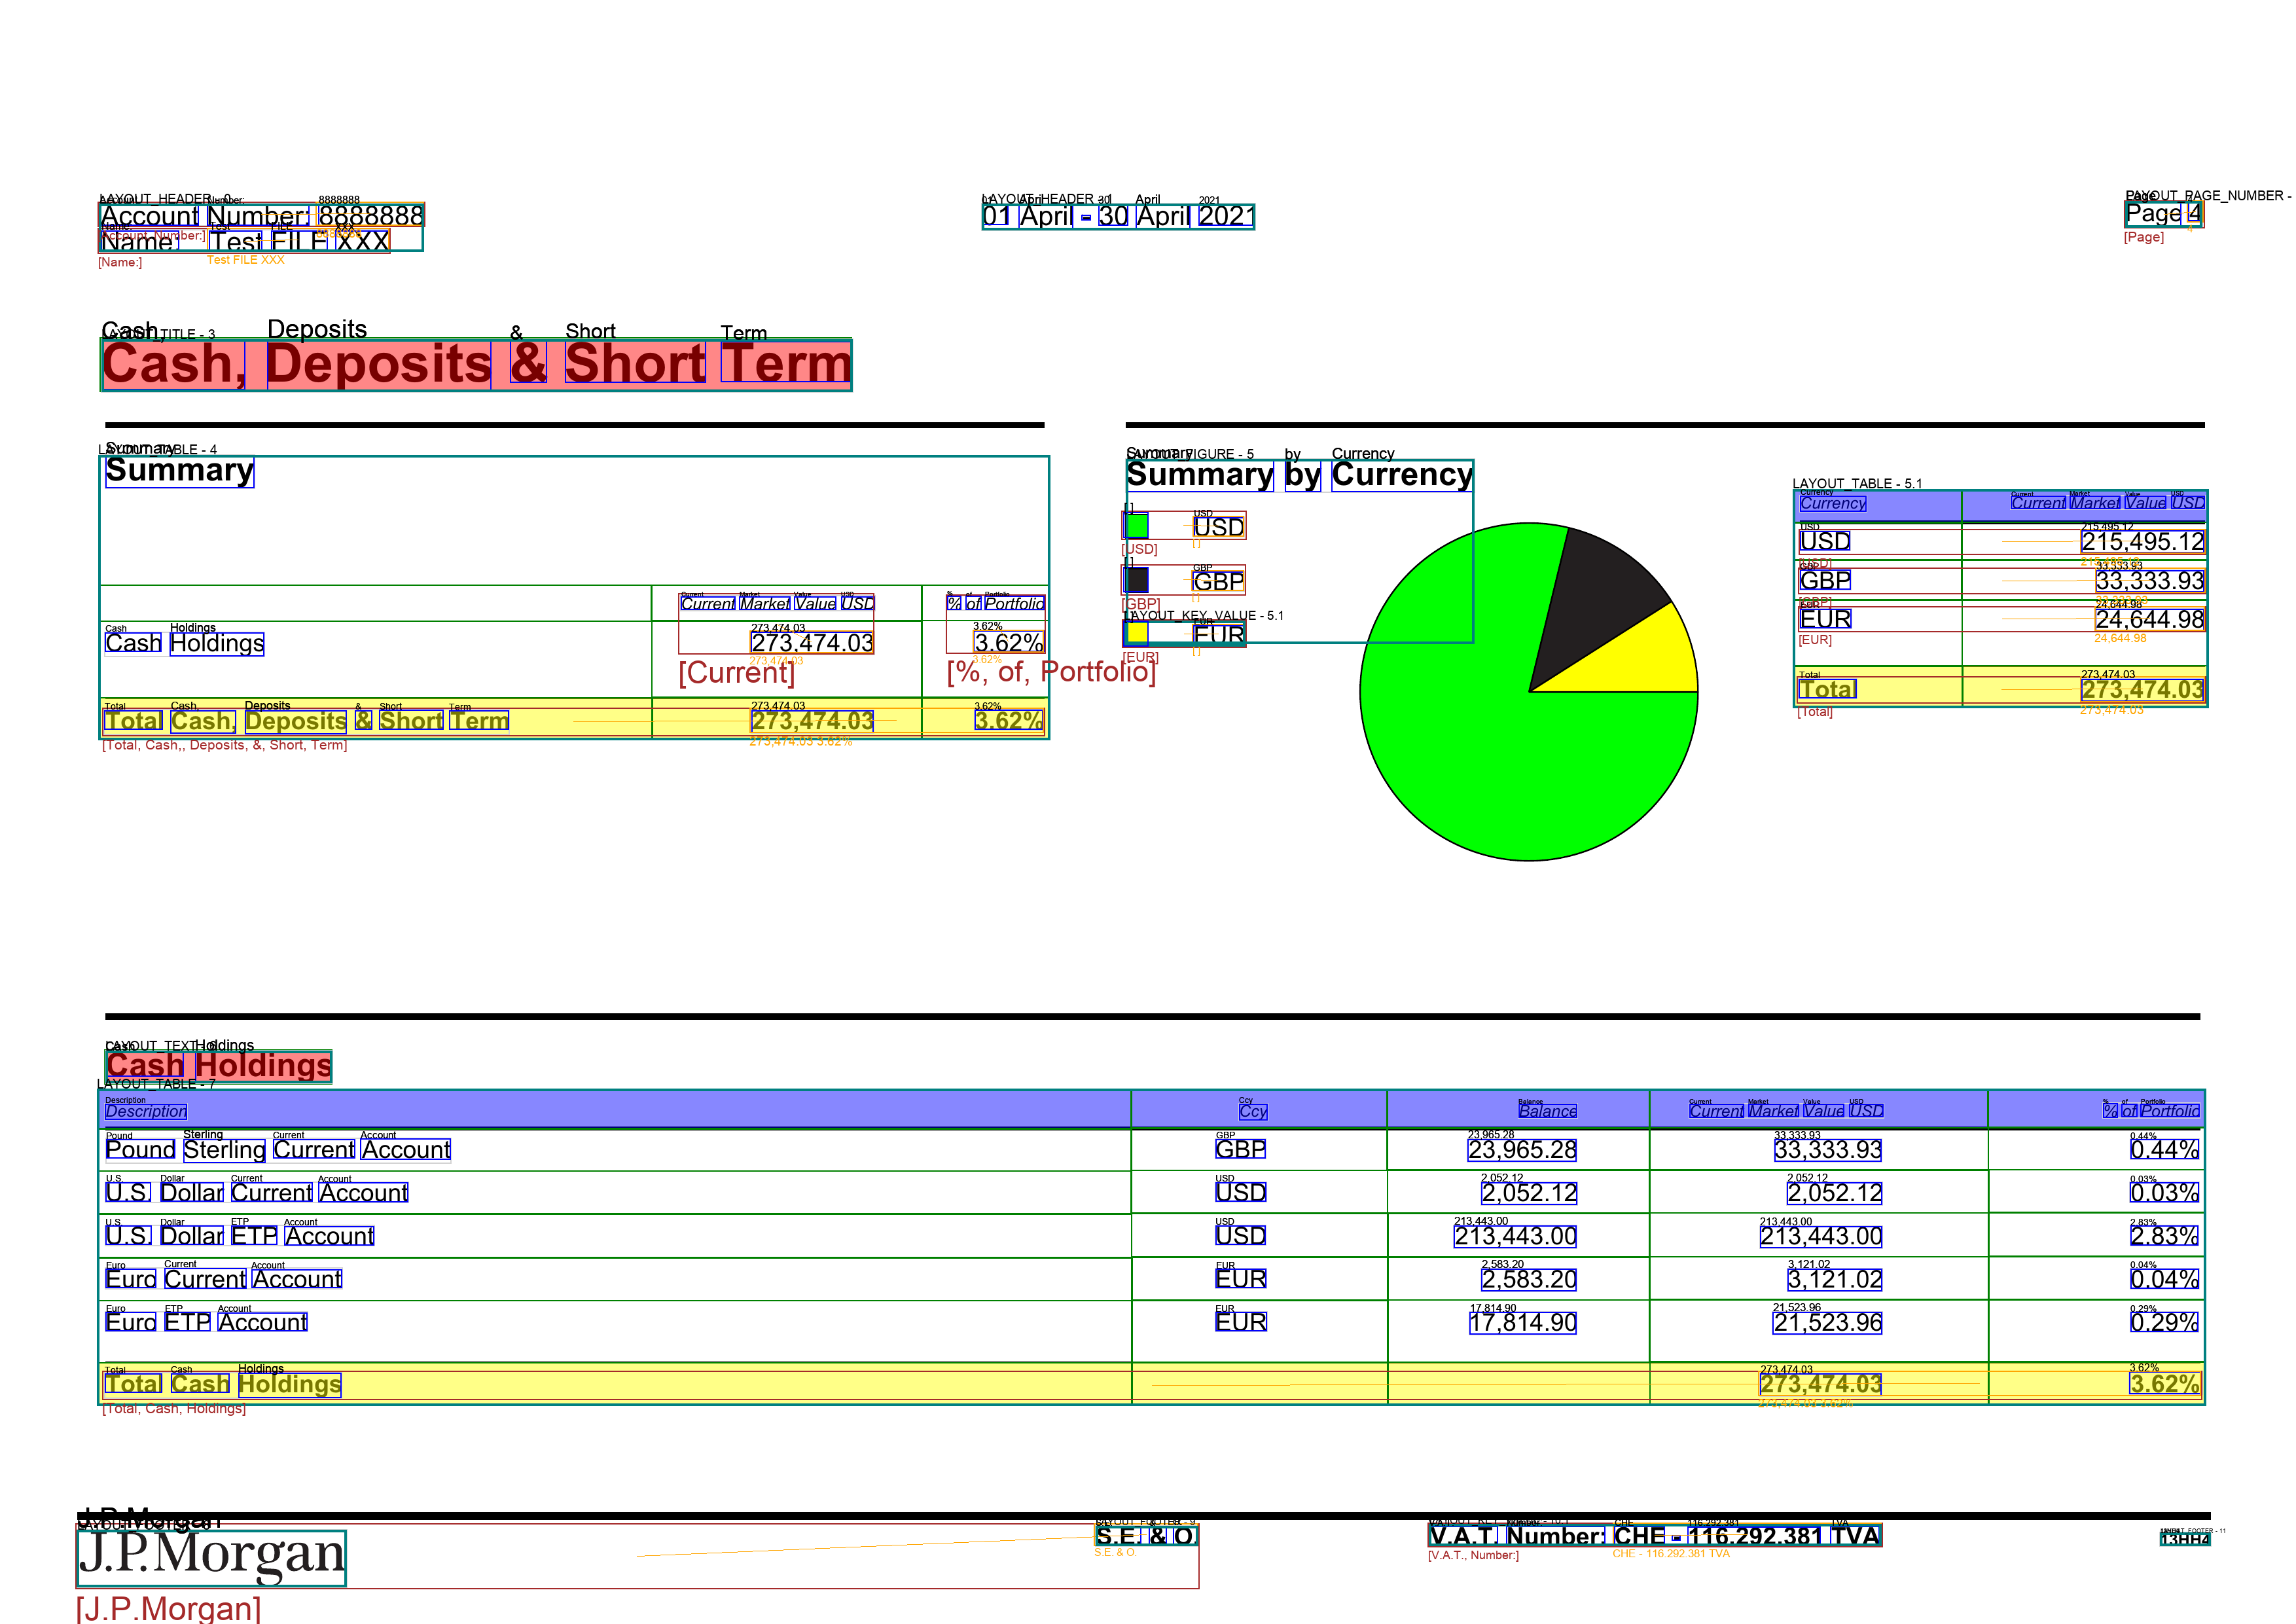

In [157]:
document.pages[3].visualize()
# document.pages[1].page_layout.titles.visualize()
# document.pages[1].page_layout.headers.visualize()   # can be removed

# document.pages[1].page_layout.section_headers.visualize()
# document.pages[1].page_layout.footers.visualize()     # can be removed
# document.pages[1].page_layout.tables.visualize()
# document.pages[3].page_layout.key_values.visualize()  # content which cannot be classified
# document.pages[1].page_layout.page_numbers.visualize()
# document.pages[1].page_layout.lists.visualize()
# document.pages[1].page_layout.figures.visualize()

Convert into HTML.

In [167]:
OUTPUT_FILE = 'output.html'

In [168]:
from IPython.display import display, HTML

html = document.to_html()

with open(OUTPUT_FILE, 'w') as f:
    f.write(html)

# # Test
# display(HTML(html))

## Tables Extraction using LLM on Bedrock

Pre-requisite: 
- Configure Amazon Bedrock model access for your account and region.

Function to call Bedrock and return a response.

In [238]:
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError

# Use longer timeout waiting for result (default 60s)
config = Config(read_timeout=1000)
bedrock_client = boto3.client(service_name='bedrock-runtime', config=config)

def get_completion_from_llm(user_message, system_prompt=None, prefill=None, modelId=None):
    """
    Get a completion from an LLM model.
    """
    if not modelId:
        modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
        
    inference_config = {
        "temperature": 0.0,
         "maxTokens": 4096
    }

    # Construct params for converse API
    converse_api_params = {
        "modelId": modelId,
        "messages": [user_message],
        "inferenceConfig": inference_config
    }
    if system_prompt:
        converse_api_params["system"] = [{"text": system_prompt}]
    if prefill:
        converse_api_params["messages"].append({"role": "assistant", "content": [{"text": prefill}]})

    # Use bedrock client to call LLM
    try:
        response = bedrock_client.converse(**converse_api_params)
        text_content = response['output']['message']['content'][0]['text']
        return text_content

    except ClientError as err:
        message = err.response['Error']['Message']
        print(f"A client error occured: {message}")

In [169]:
with open(OUTPUT_FILE) as f:
    html_content = f.read()

Define the prompt.

In [307]:
system_prompt = """
You’re an experienced financial analyst. Extract data from financial reports based on requirements.
"""

prefill = 'Assistant: '

### HTML Files Output

In [285]:
user_prompt_template = f"""
Extract data from the HTML document. Complete all tasks defined in the <tasks> by filling the HTML tables with extracted data from the document.

<instructions>
1. Use numbers from the document only.
2. Do not make up any number if the respective value is not available.
3. Format date value in "yyyy/MM/dd" format.
</instructions>

<task>
TASK_DESCRIPTION
</task>

<example>
<table></table>
</example>
"""

In [257]:
tasks = [
    {"name": "Holding in Cash, Deposits & Short Term",
        "description": """Holding in Cash, Deposits & Short Term
Find all holdings in Cash, Deposits & Short Term from the report. Respond only the HTML table with following headers:
PortfolioId	AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP	MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
"""},
    {"name": "Holdings in Equity",
"description": """Holdings in Equity
Find all holdings in Equities from the report. Respond only the HTML table with following headers:
PortfolioId	AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP	MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
"""},
    {"name": "Holding in Options Swaps & Structure Assets",
"description": """Holding in Options Swaps & Structure Assets
Find all holdings in Options, Swaps & Structured Assets from the report. Respond only the HTML table with following headers:
PortfolioId	AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP	MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
"""},
    {"name": "Transaction Records",
     "description": """Transaction Records
Find all transactions in the report. Respond only in the HTML table with following headers:
CanopyCcyAccount,PortfolioId,AccountNumber,Currency,TradeDate,ValueDate,Narration,SettlementAmount,Quantity,TransactedPrice,DirtyPrice,ISINCode,BankSecurityIdentifier,TransactionTypeFromBank,BankReferenceId,CanopyTicker,CanopyTransactionType,BBGIdentifier,RIC,Valoren/WKN,Cusip,NameDescription,Coupon,Maturity,StartDate,GrossSettlementAmount,Underlying,MoreInfo,InstrumentType,AssetClass,SubAssetClass,FXRate,MultiplierRealizedPnL,RealizedPnLMkt,RealizedPnLFx,RealizedPnLCcy,RealizedPnLMktCcy,RealizedPnLFxCcy,AccruedInterest,WithholdingTax,Commission,GST/VAT,StampDuty,OtherFees,OtherTaxes,AccruedInterestCcy,WithholdingTaxCcy,CommissionCcy,Gst/VatCcy,StampDutyCcy,OtherFeesCcy,OtherTaxesCcy
"""
    }
]

In [259]:
results = []

In [266]:
for idx, task in enumerate(tasks):
    print(f'Task {idx}: {task["name"]}')
    user_prompt = user_prompt_template.replace('TASK_DESCRIPTION', task["description"])
    user_message = {
        "role": "user",
        "content": [
            { "text": user_prompt },
            { "document": {
                    "format": "html",
                    "name": "financial report in html",
                    "source": {
                        "bytes": html_content
                    }
                }
            }
        ],
    }
    result = get_completion_from_llm(user_message, system_prompt, prefill)
    results.append(f'<h1>{task["name"]}</h1>')
    results.append(result)

Task 0: Holding in Cash, Deposits & Short Term
Task 1: Holdings in Equity
Task 2: Holding in Options Swaps & Structure Assets
Task 3: Transaction Records


In [267]:
display(HTML('<br><br>'.join(results)))

PortfolioId,AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP,MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
,8888888,GBP,2021/04/30,23965.28,,Cash,Pound Sterling Current Account,2021/04/30,33333.93,,,,,,,,,,,,,33333.93,GBP,,,,,,
,8888888,USD,2021/04/30,2052.12,,Cash,U.S. Dollar Current Account,2021/04/30,2052.12,,,,,,,,,,,,,2052.12,USD,,,,,,
,8888888,USD,2021/04/30,213443.0,,Cash,U.S. Dollar ETP Account,2021/04/30,213443.0,,,,,,,,,,,,,213443.0,USD,,,,,,
,8888888,EUR,2021/04/30,2583.2,,Cash,Euro Current Account,2021/04/30,3121.02,,,,,,,,,,,,,3121.02,EUR,,,,,,
,8888888,EUR,2021/04/30,17814.9,,Cash,Euro ETP Account,2021/04/30,21523.96,,,,,,,,,,,,,21523.96,EUR,,,,,,
PortfolioId,AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP,MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
,8888888,USD,2021/04/30,6935.00,73.95,Equities,NOVO-NORDISK AS SPONSORED ADR,2021/04/30,512843.25,,,72.47,,,,,,,,,,512843.25,USD,,,,,,
,8888888,EUR,2021/04/30,923.00,666.50,Equities,KERING SA,2021/04/30,743259.67,,,548.38,,,,,,,,,,743259.67,EUR,,,,,,
,8888888,EUR,2021/04/30,1275.00,341.65,Equities,LOREAL,2021/04/30,526296.31,,,327.92,,,,,,,,,,526296.31,EUR,,,,,,
,8888888,EUR,2021/04/30,1475.00,256.85,Equities,ADIDAS AG,2021/04/30,457730.98,,,285.08,,,,,,,,,,457730.98,EUR,,,,,,


In [275]:
with open('result.html', 'w') as f:
    f.write('<br><br>'.join(results))

### JSON Files Output

In [347]:
user_prompt_template = f"""
Extract data from the HTML document. Complete all tasks defined in the <tasks> by filling the tables with extracted data from the document.

<task>
TASK_DESCRIPTION
</task>

<instructions>
1. Use numbers from the document only.
2. Do not make up any number if the respective value is not available.
3. Format date value in "yyyy/MM/dd" format.
4. Convert and provide the tables in CSV format.
5. Do not include any comment, prompt or instruction. It is very important that you only provide the final output without any additional text.
</instructions>

Provide the table in CSV format as the final output.
"""

In [348]:
tasks = [
    {"name": "Holding in Cash, Deposits & Short Term",
        "description": """Holding in Cash, Deposits & Short Term
Find all holdings in Cash, Deposits & Short Term from the report. Construct the table with following headers. Respond with only the table in CSV format.
PortfolioId,AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP	MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
"""},
    {"name": "Holdings in Equity",
"description": """Holdings in Equity
Find all holdings in Equities from the report. Construct the table with following headers. Respond with only the table in CSV format.
PortfolioId,AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP	MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
"""},
    {"name": "Holding in Options Swaps & Structure Assets",
"description": """Holding in Options Swaps & Structure Assets
Find all holdings in Options, Swaps & Structured Assets from the report. Construct the table with following headers. Respond with only the table in CSV format.
PortfolioId,AccountNumber,Currency,ValueDate,Quantity,Price,InstrumentType,NameDescription,PriceDate,MarketValue,ISINCode,BankSecurityIdentifier,AvgPurchasePrice,DirtyPrice,CanopyTicker,Coupon,Maturity,StartDate,BBGIdentifier,RIC,Valoren/WKN,CUSIP	MarketValueInFXCY,FXCY,AccruedInterestPct,AccruedInterestAbs,AccruedInterestAbsFxcy,PurchaseDate,PriceMultiplier,Underlying
"""},
    {"name": "Transaction Records",
     "description": """Transaction Records
Find all transactions in the report. Construct the table with following headers. Respond with only the table in CSV format.
CanopyCcyAccount,PortfolioId,AccountNumber,Currency,TradeDate,ValueDate,Narration,SettlementAmount,Quantity,TransactedPrice,DirtyPrice,ISINCode,BankSecurityIdentifier,TransactionTypeFromBank,BankReferenceId,CanopyTicker,CanopyTransactionType,BBGIdentifier,RIC,Valoren/WKN,Cusip,NameDescription,Coupon,Maturity,StartDate,GrossSettlementAmount,Underlying,MoreInfo,InstrumentType,AssetClass,SubAssetClass,FXRate,MultiplierRealizedPnL,RealizedPnLMkt,RealizedPnLFx,RealizedPnLCcy,RealizedPnLMktCcy,RealizedPnLFxCcy,AccruedInterest,WithholdingTax,Commission,GST/VAT,StampDuty,OtherFees,OtherTaxes,AccruedInterestCcy,WithholdingTaxCcy,CommissionCcy,Gst/VatCcy,StampDutyCcy,OtherFeesCcy,OtherTaxesCcy
"""
    }
]

In [349]:
results = []

In [350]:
for idx, task in enumerate(tasks):
    print(f'Task {idx}: {task["name"]}')
    user_prompt = user_prompt_template.replace('TASK_DESCRIPTION', task["description"])
    user_message = {
        "role": "user",
        "content": [
            { "text": user_prompt },
            { "document": {
                    "format": "html",
                    "name": "financial report in html",
                    "source": {
                        "bytes": html_content
                    }
                }
            }
        ],
    }
    result = get_completion_from_llm(user_message, system_prompt, prefill)

    # Export data into JSON file
    with open(f'{task["name"]}.csv', 'w') as f:
        f.write(result)
        
    results.append(result)

Task 0: Holding in Cash, Deposits & Short Term
Task 1: Holdings in Equity
Task 2: Holding in Options Swaps & Structure Assets
Task 3: Transaction Records


#### Reference

- chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://d1.awsstatic.com/events/Summits/reinvent2023/AIM322-R_Intelligent-document-processing-with-generative-AI-for-public-sector-REPEAT.pdf
- https://github.com/aws-samples/layout-aware-document-processing-and-retrieval-augmented-generation/tree/main
- https://aws.amazon.com/blogs/machine-learning/implement-smart-document-search-index-with-amazon-textract-and-amazon-opensearch/